In [1]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np

# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt

# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib

# pandas用ライブラリ
import pandas as pd

# データフレーム表示用関数
from IPython.display import display

# seaborn
import seaborn as sns

# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode="fixed")
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams["figure.figsize"] = (6, 6)
# 方眼表示ON
plt.rcParams["axes.grid"] = True
# データフレームでの表示精度
pd.options.display.float_format = "{:.3f}".format
# データフレームですべての項目を表示
pd.set_option("display.max_columns", None)

In [2]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

Running on PyMC v5.25.1
Running on ArViz v0.22.0


In [3]:
# アイリスデータセットの読み込み
df = sns.load_dataset("iris")

# 先頭5行の確認
display(df.head())

#  speciesの分布確認
df["species"].value_counts()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa


species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

In [4]:
# 花の種類をsetosa以外の２種類に絞り込む
df2 = df.query('species != "setosa"')

# インデックスを0から振り直す
df2 = df2.reset_index(drop=True)

# petal_widthの項目値をx_dataにセット
X = df2["petal_width"].values

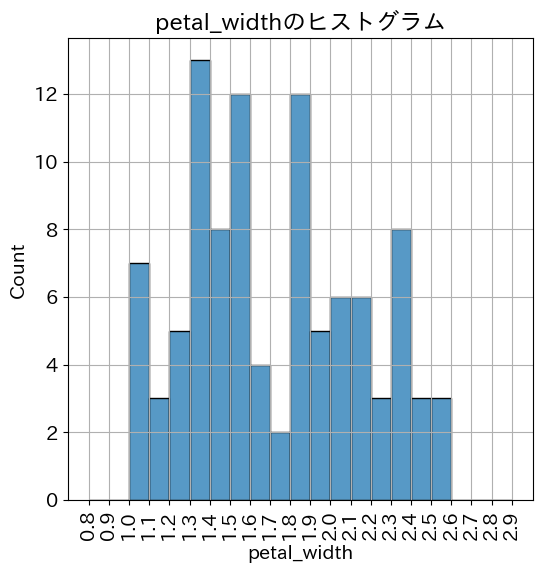

In [5]:
bins = np.arange(0.8, 3.0, 0.1)
fig, ax = plt.subplots()
sns.histplot(bins=bins, x=X)
ax.set_xlabel("petal_width")
ax.xaxis.set_tick_params(rotation=90)
ax.set_title("petal_widthのヒストグラム")
ax.set_xticks(bins)

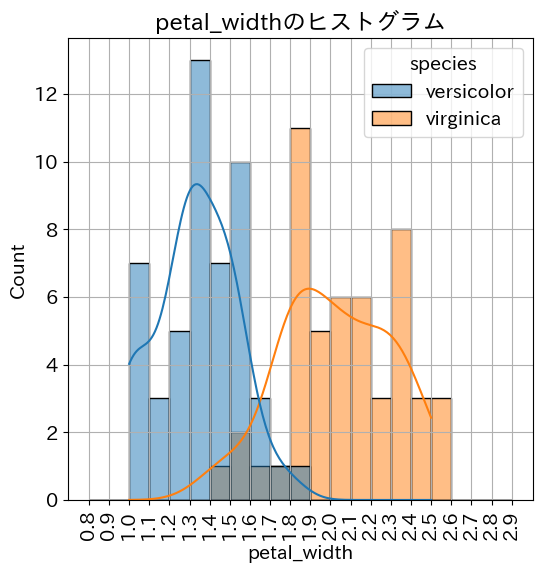

In [6]:
bins = np.arange(0.8, 3.0, 0.1)
fig, ax = plt.subplots()
sns.histplot(data=df2, bins=bins, x="petal_width", hue="species", kde=True)
ax.xaxis.set_tick_params(rotation=90)
ax.set_title("petal_widthのヒストグラム")
ax.set_xticks(bins)

In [7]:
# 変数の初期設定

# 何種類の正規分布モデル（混合成分）を仮定するか。
# ここでは「2つの花の種類が混ざって観測されている」という想定で、
# 2成分のガウス混合モデル（Gaussian Mixture Model, GMM）になっている。
n_components = 2

# 観測データ件数（サンプル数）を表すつもりの変数。
# 注意：X.shape は (N,) のような「タプル」を返すので、
# shape を pm 変数の shape に渡すなら通常は X.shape[0] のように
# 整数のサンプル数を使うのが自然である。
# ただし PyMC はタプル shape も許すケースがあるため、ここでは元コードを保持する。
N = X.shape

# PyMC の確率モデルコンテナを作成
model1 = pm.Model()

with model1:
    # X の観測値を Data ノードとしてモデルに埋め込む。
    # これにより「X を固定した条件付きモデル p(X | latent params)」という回帰/生成の立場が明確になり、
    # 後で pm.set_data で差し替えて予測したりもできる。
    X_data = pm.Data("X_data", X)

    # p: 潜在クラス（成分）s_i が 1 をとる確率。
    # 2成分混合の場合、s_i=0 の確率は 1-p で自動的に決まる。
    # 事前は一様分布なので「どちらの成分が多いか分からない」非情報的な仮定。
    p = pm.Uniform("p", lower=0.0, upper=1.0)

    # s: 各観測 i がどちらの成分から来たかを表す潜在ラベル（割当）。
    # s_i ~ Bernoulli(p) により 0/1 を返し、shape=N で全観測分のラベル列を作る。
    # これは「観測ごとの隠れ変数による mixture のスイッチ」を実装している。
    s = pm.Bernoulli("s", p=p, shape=N)

    # mus: 各成分 k の平均 μ_k。
    # 0 を中心に十分広い正規事前を置いており、データから平均位置を学習させる。
    mus = pm.Normal("mus", mu=0.0, sigma=10.0, shape=n_components)

    # taus: 各成分 k の精度（precision）τ_k。
    # 精度は分散の逆数に対応し、τ_k = 1 / σ_k^2 の関係がある。
    # HalfNormal を使うことで τ_k > 0（分散は正）という制約を自然に満たす。
    taus = pm.HalfNormal("taus", sigma=10.0, shape=n_components)

    # sigmas: 各成分 k の標準偏差 σ_k を、精度 τ_k から決定論的に計算して持っておく。
    # τ_k = 1/σ_k^2 なので σ_k = 1/√τ_k。
    # 理論的には単なる再パラメータ化だが、可視化や解釈には σ の方が直感的なので
    # Deterministic ノードとして保存しておくのが便利。
    sigmas = pm.Deterministic("sigmas", 1 / pm.math.sqrt(taus))

    # mu: 各観測 i に対応する平均 μ_{s_i} を潜在ラベルで切り替えて取得。
    # すなわち
    #   mu_i = mus[0]  if s_i=0
    #   mu_i = mus[1]  if s_i=1
    # という mixture の平均部分を表す決定論的変数。
    mu = pm.Deterministic("mu", mus[s])

    # tau: 各観測 i に対応する精度 τ_{s_i} を潜在ラベルで切り替えて取得。
    # こちらも mixture の分散（精度）部分を観測ごとに選択している。
    tau = pm.Deterministic("tau", taus[s])

    # 観測モデル（尤度）:
    # 各 X_i は、割当 s_i で選ばれた成分の正規分布に従う、という生成過程を表現。
    # つまり
    #   X_i | s_i=k, mus, taus  ~ Normal(mus[k], 1/taus[k])
    # を全 i についてまとめて書いている。
    X_obs = pm.Normal("X_obs", mu=mu, tau=tau, observed=X_data)

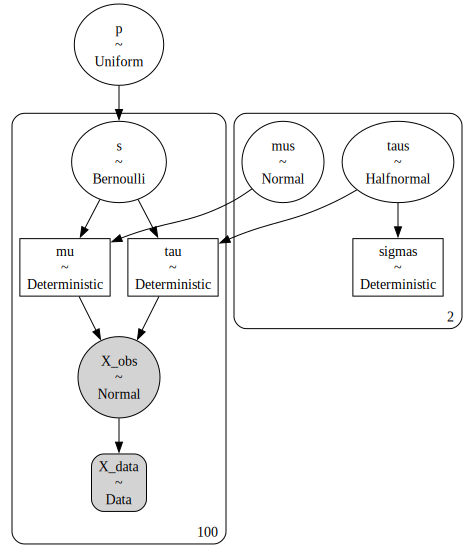

In [8]:
g = pm.model_to_graphviz(model1)
display(g)